## Introduction

This project is a sentiment analysis of an Amazon product review with the aim of classifying each review as positive, negative or neutral and recommending a Machine Learning model that best analyzes and assigns sentiments. Natural Language Processing techniques, Logistic Regression, Random Forest Classifier and K-Nearest Neighbours will be used in the analysis. 

In [39]:
#Importing the libraries for data manipulation and visualization
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Importing libraries for NLP
import spacy
import re
from spacy.lang.en.stop_words import STOP_WORDS
import nltk

# Importing the libraries for model and validation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Importing the libraries for metrics and reporting 
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [42]:
df = pd.read_table('Amazon Product Review.txt', delimiter=',')

In [43]:
# Previewing the dataset
df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1


In [44]:
# Overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30846 entries, 0 to 30845
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   marketplace        30846 non-null  object
 1   customer_id        30846 non-null  int64 
 2   review_id          30846 non-null  object
 3   product_id         30846 non-null  object
 4   product_parent     30846 non-null  int64 
 5   product_title      30846 non-null  object
 6   product_category   30846 non-null  object
 7   star_rating        30846 non-null  int64 
 8   helpful_votes      30846 non-null  int64 
 9   total_votes        30846 non-null  int64 
 10  vine               30846 non-null  object
 11  verified_purchase  30846 non-null  object
 12  review_headline    30846 non-null  object
 13  review_body        30846 non-null  object
 14  review_date        30846 non-null  object
 15  sentiment          30846 non-null  int64 
dtypes: int64(6), object(10)
memory usage: 3.

In [45]:
df.shape  # 16 columns and 30846 rows

(30846, 16)

In [46]:
# Finding missing values
df.isnull().sum()

marketplace          0
customer_id          0
review_id            0
product_id           0
product_parent       0
product_title        0
product_category     0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
review_date          0
sentiment            0
dtype: int64

In [47]:
# Checking duplicate values
df.duplicated().any()

False

### Exploratory Data Analysis (EDA)

In [48]:
# Print target distribution
df["sentiment"].value_counts()

1    25767
0     5079
Name: sentiment, dtype: int64

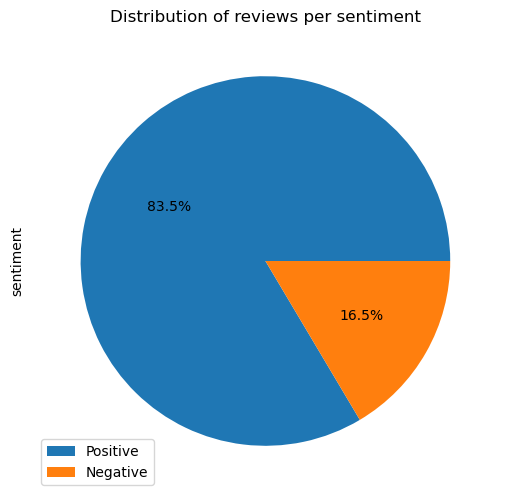

In [49]:
df['sentiment'].value_counts().plot.pie(figsize=(6,6),title="Distribution of reviews per sentiment",labels=['',''],autopct='%1.1f%%')
labels=["Positive","Negative"]
plt.legend(labels,loc=3)
plt.gca().set_aspect('equal')


There are more positive sentiments (83.5%) than negative (16.5%) which shows customers positive disposition to the product

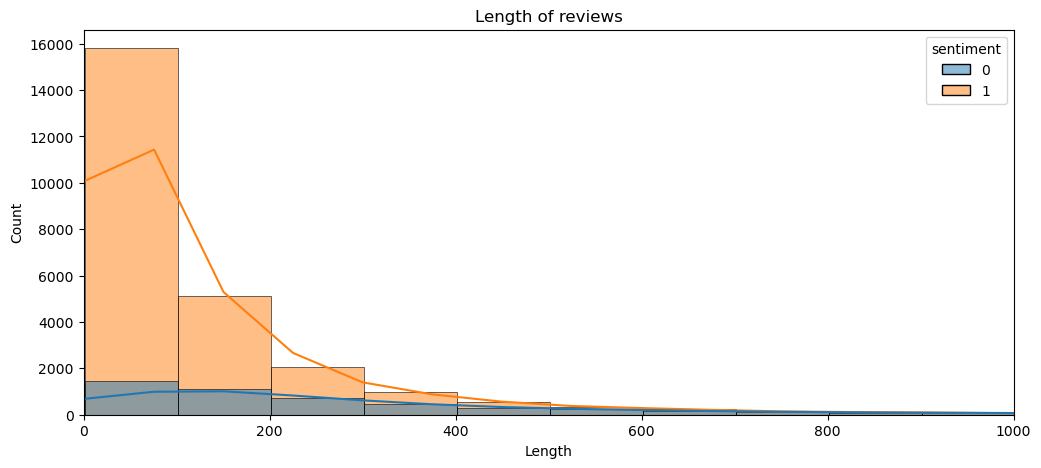

In [50]:
# Calculate length of each review
len_df = pd.concat([df.loc[:,"review_body"].map(lambda x:len(x)),df.loc[:,"sentiment"]],axis=1)

# Plot distribution
plt.figure(figsize=(12,5))
sns.histplot(data=len_df, x="review_body", hue="sentiment", binwidth=100, kde=True)
plt.title("Length of reviews")
plt.xlabel("Length")
plt.xlim([0,1000])
plt.show()

In [51]:
print("Average positive review length:", len_df.loc[len_df["sentiment"]== 1,"review_body"].mean())
print("Average negative review length:", len_df.loc[len_df["sentiment"]== 0,"review_body"].mean())

Average positive review length: 140.6709356929406
Average negative review length: 350.09076589879896


This shows negative reviews are longer than positive reviews on the average

5    20019
4     5748
3     2216
1     1708
2     1155
Name: star_rating, dtype: int64


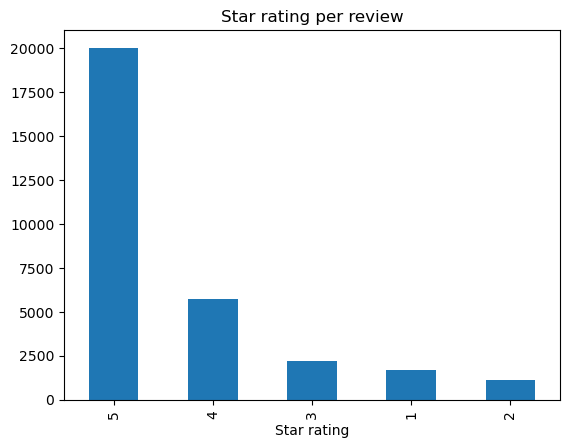

In [52]:
# Calculate star rating of review
star_rating = df["star_rating"].value_counts()
print(star_rating)

# Plot distribution
star_rating.plot.bar()
plt.title("Star rating per review")
plt.xlabel("Star rating")
plt.show()

There were more 5 star ratings in the reviews which is a good thing

### Data Preprocesssing

In [53]:
# Clean the text
def clean_text(Review):
    # Convert text to lowercase
    Review = str(Review).lower()  
    # Remove words enclosed in square brackets
    Review = re.sub('\[.*?\]', '', Review)
    # Remove words enclosed in angle brackets
    Review = re.sub('<.*?>+', '', Review)
    # Remove hyperlinks and URLs
    Review = re.sub('https?://\S+|www\.\S+', '', Review)
    # Remove numbers
    Review = re.sub(r'[^a-z0-9\s]', '', Review)
    Review = re.sub('\n', '', Review)
    Review = re.sub('\w*\d\w*', '', Review)
    return Review

# Clean entire dataset
df['clean_review'] = df['review_body'].apply(clean_text)

### Stopwords removal

In [54]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\akinj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [55]:
#clean stopwords
stopword = set(stopwords.words('english'))
def clean_stopwords(text):
    text = ' '.join(word for word in text.split() if word not in stopword) 
    return text
   
df['review_sw'] = df['clean_review'].apply(clean_stopwords)

### Lemmatization

Lemmatization is a linguistic process used in Natural Language Processing (NLP) to reduce words to their base or root form, called a lemma. The lemma is a canonical form of a word, which represents its dictionary form or morphological variant example the lemma of the word 'better. is 'good' and 'running. is 'run'

In [56]:
nlp = spacy.load("en_core_web_sm")

In [57]:
def lemmatization (text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    return ' '.join(tokens)

# Apply lemmatization function
df['review_cleaned'] = df['review_sw'].apply(lemmatization)

In [58]:
df

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,sentiment,clean_review,review_sw,review_cleaned
0,US,11555559,R1QXC7AHHJBQ3O,B00IKPX4GY,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,Great love it,2015-08-31,1,great love it,great love,great love
1,US,31469372,R175VSRV6ZETOP,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,3,0,0,N,N,Lots of ads Slow processing speed Occasionally...,Lots of ads<br />Slow processing speed<br />Oc...,2015-08-31,0,lots of adsslow processing speedoccasionally s...,lots adsslow processing speedoccasionally shut...,lot adsslow processing speedoccasionally shut ...
2,US,26843895,R2HRFF78MWGY19,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Well thought out device,Excellent unit. The versatility of this table...,2015-08-31,1,excellent unit the versatility of this tablet...,excellent unit versatility tablet besides comp...,excellent unit versatility tablet competitivel...
3,US,19844868,R8Q39WPKYVSTX,B00LCHSHMS,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,0,0,N,N,Not all apps/games we were looking forward to ...,I bought this on Amazon Prime so I ended up bu...,2015-08-31,1,i bought this on amazon prime so i ended up bu...,bought amazon prime ended buying one camera ok...,buy amazon prime end buy camera okay love edit...
4,US,1189852,R3RL4C8YP2ZCJL,B00IKPZ5V6,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,0,0,N,Y,Five Stars,All Amazon products continue to meet my expect...,2015-08-31,1,all amazon products continue to meet my expect...,amazon products continue meet expectations,amazon product continue meet expectation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30841,US,44834233,R366C7ARIWLN7R,B00IKPW0UA,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,3720,3875,N,Y,A great upgrade for me from an older Kindle Fire!,[[VIDEOID:moP3B6GS5RL8LY]]I purchased the orig...,2014-10-03,1,i purchased the original kindle fire in and t...,purchased original kindle fire second generati...,purchase original kindle fire second generatio...
30842,US,13376158,R35PL0AOCUXLU9,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,2716,2849,N,Y,Great Value for $139,I'm writing this review with the benefit of be...,2014-10-03,1,im writing this review with the benefit of bei...,im writing review benefit experienced kindle f...,m write review benefit experience kindle fire ...
30843,US,40485963,R18ZJVY86AUFII,B00KC6XV58,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,5,1525,1629,N,Y,Even grandma has it figured out!,"I purchased this Kindle for my grandma, becaus...",2014-10-03,1,i purchased this kindle for my grandma because...,purchased kindle grandma wanted simple way vid...,purchase kindle grandma want simple way video ...
30844,US,33485035,R36QVLQXMCZRSJ,B00IKPYKWG,2693241,"Fire HD 7, 7"" HD Display, Wi-Fi, 8 GB",PC,4,143,163,N,Y,The Honda Accord of Tablets,I bought my tablet Fire HD 7 at Best Buy on th...,2014-10-03,1,i bought my tablet fire hd at best buy on the...,bought tablet fire hd best buy day came hadnt ...,buy tablet fire hd good buy day come not plan ...


In [59]:
# Split features and labels
X = df["review_cleaned"]
y = df["sentiment"]

# Vectorize your data
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(df['review_cleaned'])

# Split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

# Print the shapes of the train and test sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(24676, 17203) (6170, 17203) (24676,) (6170,)


In [60]:
# Define the resampling method
sm = SMOTE(random_state=42)

# Create the resampled feature set
X_resampled, y_resampled = sm.fit_resample(X, df['sentiment'])

# Split your resampled data 
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=42, test_size=0.20)

### Model Building

### (a) Logistic Regression

In [61]:
# Instantiate the classifier
model_LR = LogisticRegression()
# Train the classifier
model_LR.fit(X_train,y_train)

LogisticRegression()

In [62]:
# Predicting the class label
pred_LR = model_LR.predict(X_test)

In [63]:
def Confusion_Matrix(y_test,ypred):
    cfmat = confusion_matrix(y_test,ypred)
    print('Confusion Matrix: \n',classification_report(y_test,ypred,labels=[0,1]))
    print("\n")
    print('TN - True Negative {}'.format(cfmat[1,1]))
    print('FP - False Positive {}'.format(cfmat[1,0]))
    print('FN - False Negative {}'.format(cfmat[0,1]))
    print('TP - True Positive {}'.format(cfmat[0,0]))
    print('Accuracy Rate: {}'.format(np.divide(np.sum([cfmat[0,0],cfmat[1,1]]),np.sum(cfmat))))
    print('Misclassification Rate: {}'.format(np.divide(np.sum([cfmat[0,1],cfmat[1,0]]),np.sum(cfmat))))
    print('F1-Score: {}'.format(f1_score(y_test, ypred,average='macro')))
    print('ROC-AUC {}'.format(roc_auc_score(y_test,ypred)))

In [64]:
Confusion_Matrix(y_test,pred_LR)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.86      0.92      0.89      5180
           1       0.92      0.85      0.88      5127

    accuracy                           0.88     10307
   macro avg       0.89      0.88      0.88     10307
weighted avg       0.89      0.88      0.88     10307



TN - True Negative 4344
FP - False Positive 783
FN - False Negative 403
TP - True Positive 4777
Accuracy Rate: 0.8849325700979916
Misclassification Rate: 0.11506742990200834
F1-Score: 0.8847291326958033
ROC-AUC 0.8847399413958805


### (b) Random Forest Classifier

In [65]:
# Instantiate the classifier
model_RF = RandomForestClassifier(n_estimators=200, random_state=0)
# Train the classifier
model_RF.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=0)

In [68]:
RandomForestClassifier(n_estimators=200, random_state=0)


RandomForestClassifier(n_estimators=200, random_state=0)

In [69]:
# Predicting the class label
pred_RF = model_RF.predict(X_test)

In [70]:
Confusion_Matrix(y_test,pred_RF)

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.91      0.96      0.94      5180
           1       0.96      0.90      0.93      5127

    accuracy                           0.93     10307
   macro avg       0.94      0.93      0.93     10307
weighted avg       0.94      0.93      0.93     10307



TN - True Negative 4636
FP - False Positive 491
FN - False Negative 193
TP - True Positive 4987
Accuracy Rate: 0.9336373338507811
Misclassification Rate: 0.06636266614921897
F1-Score: 0.9335602829971107
ROC-AUC 0.933486903688776


### (c) K-Nearest Neighbor (KNN)

In [71]:
# Instantiate the classifier
model_knn = KNeighborsClassifier()
# Train the classifier
model_knn.fit(X_train, y_train)

KNeighborsClassifier()

In [72]:
# Predicting the class label
pred_knn = model_knn.predict(X_test)

In [73]:
Confusion_Matrix(y_test,pred_knn) 

Confusion Matrix: 
               precision    recall  f1-score   support

           0       0.64      0.98      0.78      5180
           1       0.95      0.46      0.62      5127

    accuracy                           0.72     10307
   macro avg       0.80      0.72      0.70     10307
weighted avg       0.80      0.72      0.70     10307



TN - True Negative 2334
FP - False Positive 2793
FN - False Negative 119
TP - True Positive 5061
Accuracy Rate: 0.7174735616571263
Misclassification Rate: 0.2825264383428738
F1-Score: 0.6962077262511726
ROC-AUC 0.7161320038587446


### Model Evaluation: Logistic Regression vs Random Forest Classifier vs KNN

Logistic Regression achieved an accuracy of 88.49%, with precision rates of 86% for class 0 and 92% for class 1, and recall rates of 92% for class 0 and 85% for class 1. Its F1-Scores were 88% for class 0 and 88% for class 1, while the ROC-AUC score was 88.47%. In its confusion matrix, it had 4344 true negatives, 783 false positives, 403 false negatives, and 4777 true positives.

The Random Forest Classifier outperformed others with an accuracy of 93.36%, precision rates of 91% for class 0 and 96% for class 1, and recall rates of 96% for class 0 and 90% for class 1. Its F1-Scores were 94% for class 0 and 93% for class 1, while the ROC-AUC score was 93.35%. In its confusion matrix, it had 4636 true negatives, 491 false positives, 193 false negatives, and 4987 true positives.

K-Nearest Neighbors (KNN) achieved an accuracy of 71.75%, with precision rates of 64% for class 0 and 95% for class 1, and recall rates of 98% for class 0 and 46% for class 1. Its F1-Scores were 78% for class 0 and 62% for class 1, while the ROC-AUC score was 71.61%. In its confusion matrix, it had 2334 true negatives, 2793 false positives, 119 false negatives, and 5061 true positives.

Based on the evaluation metrics, the Random Forest Classifier appears to be the best-performing model among the three, considering its high accuracy, precision, recall, F1-score, and ROC-AUC score. It consistently outperforms Logistic Regression and K-Nearest Neighbors across all metrics. Therefore, I recommend choosing the Random Forest Classifier for sentiment analysis of Amazon product reviews.